In [ ]:
#### Spacecraft Anomally Project ####

In [10]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn

# read the data sets
anom_data = pd.read_csv(r'anomaly.csv',na_values='missing')
tdr_data = pd.read_csv(r'tdrs5j.csv',na_values='missing')

# concatenate the data sets
anom_data = pd.concat([anom_data.copy(),tdr_data],axis=0)

# fill in nan rows
anom_data.fillna('missing', inplace=True)
print(anom_data.shape[0])

10844


In [110]:
# Turn the date columns into date objects
anom_data.ADATE = pd.to_datetime(anom_data.ADATE,format='%m/%d/%Y')
anom_data.EDATE = pd.to_datetime(anom_data.EDATE,format='%m/%d/%Y')

# Turn lowercase to uppercase
anom_data['ORBIT'].replace('g', 'G')
    

# drop rows that have missing orbits and anomally types
anom_data = anom_data[anom_data.ATYPE != 'missing']
anom_data = anom_data[anom_data.ORBIT != 'missing']
anom_data = anom_data[anom_data.SVE != 'missing']

anom_data['AMONTH'] = anom_data['ADATE'].dt.month
anom_data['AYEAR'] = anom_data['ADATE'].dt.year
anom_data['ADAY'] = anom_data['ADATE'].dt.day

# turn categorical variables into discrete variables
# diagnosis, orbit type, earth sun degrees, anomally type
sort_adiag = sorted(set(anom_data.ADIAG))
sort_orbit = sorted(set(anom_data.ORBIT))
sort_atype = sorted(set(anom_data.ATYPE))
sort_ns = sorted(set(anom_data.NS))
sort_ew = sorted(set(anom_data.EW))

# create a dictionary for each column
def make_dict(column):
    d = {}
    count = 0
    for i in column:
        count+=1
        d[i] = count
    return d
dict_atype = make_dict(sort_atype)
dict_adiag = make_dict(sort_adiag)
dict_orbit = make_dict(sort_orbit)
dict_ns = make_dict(sort_ns)
dict_ew = make_dict(sort_ew)

# map the values
anom_data['ADIAG'].replace(dict_adiag, inplace=True)
anom_data['ATYPE'].replace(dict_atype, inplace=True)
anom_data['ORBIT'].replace(dict_orbit, inplace=True)
anom_data['NS'].replace(dict_ns, inplace=True)
anom_data['EW'].replace(dict_ew, inplace=True)

# bin the sun-earth degrees
bins = {}
#anom_data.SVE = pd.cut(anom_data.SVE,2)
count = 0
# j in sorted(anom_data.SVE.unique()):
#    count+=1
#    bins[j]=count
#anom_data.replace({'SVE':bins},inplace=True)

In [111]:
(anom_data.STIMEL.unique())

array([1632.0, 2138.0, 120.0, ..., 2019.0, 1403.0, 914.0], dtype=object)

In [112]:
## Binning 
# printing process
attribute={} #dictinary for attribute
for i in ['SVE','STIMEU','DUR','LAT','LON','ALT','ADAY','AMONTH','AYEAR']:
    bin_count = -1
    bins = {} #dictionary for the bin
    
    # put observations into bins
    print(i)
    anom_data[i] = pd.cut(anom_data[i],5)
    
    for j in sorted(anom_data[i].unique()): 
        bin_count+=1 #bin count is the category number for the bin
        bins[j] = bin_count #assign bin count to the bin range
        count=0
        for k in anom_data[i]:
            if k == j:
                count+=1 #if the observation matches the bin, add 1 to count
    attribute[i] = bins #assign the bins dict to the attribite for mapping
    
# map the bin (0 to 4) values
for col in ['SVE','STIMEU','DUR','LAT','LON','ALT','ADAY','AMONTH','AYEAR']:
    anom_data[col] = list(map(attribute[col].get,anom_data[col]))

SVE
STIMEU
DUR
LAT
LON
ALT
ADAY
AMONTH
AYEAR


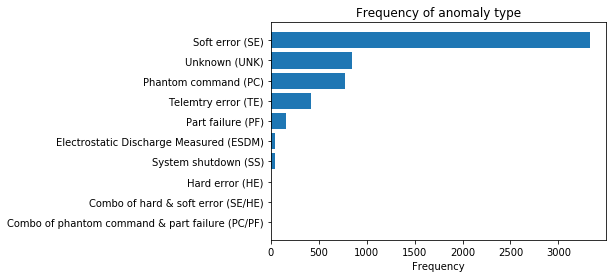

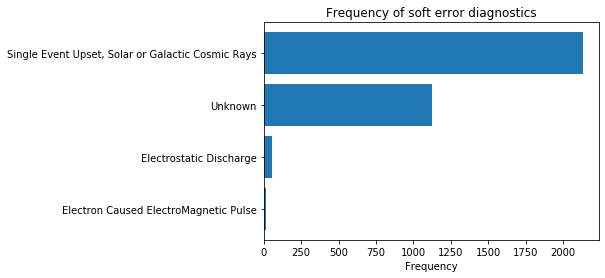

"\n# Difference between orbit types\norbit_data = anom_data.loc[:,['ATYPE','ORBIT']]\norbit_data_counts = orbit_data.groupby(by=[orbit_data.ATYPE,anom_data.ORBIT]).count()\norbit_data_counts.columns= ['Counts']\norbit_data_counts.reset_index(inplace=True)\n"

In [60]:
### Exploratory Analysis / Descriptive Analysis ###
anom_dict = {'SE':'Soft error', 'UNK':'Unknown','PC':'Phantom command','TE':'Telemtry error','ESDM':'Electrostatic Discharge Measured', 
            'PF':'Part failure','missing':'Earth Sensor Anomally','SS':'System shutdown','HE':'Hard error','ATT':'Attitude Control Problem',
            'SE/HE':'Combo of hard & soft error','PC/PF':'Combo of phantom command & part failure'}

# How many anomalies of each type
%matplotlib inline
fig, ax = plt.subplots()
anom_type = ['Soft error (SE)', 'Unknown (UNK)','Phantom command (PC)','Telemtry error (TE)','Part failure (PF)','Electrostatic Discharge Measured (ESDM)', 
            'System shutdown (SS)','Hard error (HE)','Combo of hard & soft error (SE/HE)','Combo of phantom command & part failure (PC/PF)']
y_pos = np.arange(len(anom_type))
ax.barh(y_pos, anom_data['ATYPE'].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(anom_type)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Frequency of anomaly type')
fig.savefig('anomaly_counts.png',figsize=(10,8),bbox_inches='tight')
plt.show()


# What is causing soft error anomalies
se_anom_diag = ['Single Event Upset, Solar or Galactic Cosmic Rays', 
               'Unknown', 'Electrostatic Discharge', 'Electron Caused ElectroMagnetic Pulse']
y_pos = np.arange(len(se_anom_diag))
fig,ax = plt.subplots()
ax.barh(y_pos, anom_data.loc[anom_data.ATYPE=='SE','ADIAG'].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(se_anom_diag)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Frequency of soft error diagnostics')
fig.savefig('soft_error_diagnostic_plot.png',figsize=(10,8),bbox_inches='tight')
plt.show()

'''
# Difference between orbit types
orbit_data = anom_data.loc[:,['ATYPE','ORBIT']]
orbit_data_counts = orbit_data.groupby(by=[orbit_data.ATYPE,anom_data.ORBIT]).count()
orbit_data_counts.columns= ['Counts']
orbit_data_counts.reset_index(inplace=True)
'''

In [57]:
orbit_data = anom_data.loc[:,['ATYPE','ORBIT']]
orbit_data_counts = orbit_data.groupby(by=[orbit_data.ATYPE,anom_data.ORBIT]).count()
orbit_data_counts.columns= ['Counts']
orbit_data_counts.reset_index(inplace=True)


In [58]:
orbit_data_counts

,ATYPE,ORBIT,Counts
0,ESDM,E,2
1,ESDM,G,41
2,HE,G,7
3,PC,E,1
4,PC,G,763
5,PC,P,12
6,PC/PF,G,1
7,PF,G,154
8,PF,P,1
9,SE,C,729


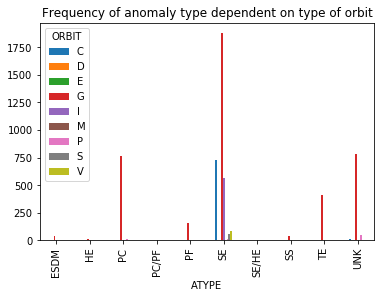

In [59]:
orbit_data_counts.pivot('ATYPE','ORBIT','Counts').plot(kind='bar', 
                                                       title='Frequency of anomaly type dependent on type of orbit')
plt.savefig('error_by_orbit_counts.png',figsize=(10,8),bbox_inches='tight')

In [114]:
for i in features:
    print(i, anom_data[i].unique())

STIMEU [1 0 2]
DUR [0 2 1 3]
ORBIT [4 3 7 6 5 1 8 2 9]
NS [3 1 2]
LAT [0 3 1 4 2]
EW [1 2 3]
LON [4 2 1 3 0]
ALT [3 4 0 2 1]
SVE [0 1 3 2 4]
SPIN ['missing' 'S']
AMONTH [3 1 4 2 0]
ADAY [1 2 4 0 3]
AYEAR [4 3 1 0 2]


In [115]:
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

features = ['STIMEU','DUR','ORBIT','NS','LAT','EW','LON','ALT','SVE','AMONTH','ADAY','AYEAR']
label = 'ATYPE'

# Split the data into training and testing
xtrain, xtest, ytrain, ytest = train_test_split(anom_data[features], anom_data[label], test_size=0.20, random_state=42)

# Split the data again into training and validation
xtrain2, xvalid, ytrain2, yvalid = train_test_split(xtrain,ytrain,test_size=0.20,random_state=42)

nb_model = MultinomialNB()
nb_model.fit(xtrain2,ytrain2)
ypred = nb_model.predict(xvalid)
print('Training accuracy:', round(metrics.accuracy_score(yvalid, ypred),2))

nb_model.fit(xtest,ytest)
ypred_test = nb_model.predict(xtest)
print('Testing accuarcy:',round(metrics.accuracy_score(ytest,ypred_test),2))


Training accuracy: 0.66
Testing accuarcy: 0.67
